In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, find_peaks_cwt
from scipy import stats
import matplotlib.pyplot as plt
import pyBigWig as bw
import torch

# load data

In [2]:
def get_signal_gt_th(signal, th, max_gap=10):
    idx = np.where(signal > th)[0]
    intervals = []
    interval = None
    for i in idx:
        # if interval is empty initialize
        if interval is None:
            interval = [i,i]
        else:
            # if current value is next to last value, add to interval
            if i <= interval[1] + max_gap:
                interval[1] = i
            else:
                # if not, add interval to list and start new interval
                intervals.append(interval)
                interval = [i,i]
    # add last interval
    if interval is not None:
        intervals.append(interval)
    
    intervals = np.array(intervals)
            
    return intervals

def get_atac_data(chrom,start,end,run_ids):
    #chrom = chrom.replace('chr','')

    #bin_size = 20
    #
    #starts = np.arange(start - start%bin_size,end + bin_size - end%bin_size,bin_size)
    #ends = starts + bin_size
    #
    #df = pd.DataFrame()
    #df['start'] = starts
    #df['end'] = ends

    #samples = pd.read_csv('/home/jbreda/ATACseq/resources/SraRunTable.txt',sep=',')

    X = np.zeros([10000,run_ids.shape[0]])

    for i,run in enumerate(run_ids):
        infile = f'/home/jbreda/ATACseq/results/mapping/{run}_coverage.bw'
        f = bw.open(infile)
        X[:,i] = f.values(chrom.replace('chr',''),start,end)

    return X

def get_atac_peaks():
    files = ['SRR8119838_accessible_regions.gappedPeak','SRR8119852_accessible_regions.gappedPeak','SRR8119839_accessible_regions.gappedPeak','SRR8119853_accessible_regions.gappedPeak']
    folder = '/home/jbreda/ATACseq/results/peaks'

    df = pd.DataFrame()
    for f in files:
        df_f = pd.read_csv(f'{folder}/{f}',sep='\t',header=None,skiprows=[0])
        df_f = df_f.loc[:,[0,1,2,6,7]]
        df_f.columns = ['chrom','start_1','end_1','start_2','end_2']
        df_f.loc[:,'sample'] = f.split('_')[0]

        df = pd.concat([df,df_f],axis=0,ignore_index=True)

    return df


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
    


         chr      start        end strand black_listed      gene  \
3204   chr11   69408675   69418675      -            .     Kdm6b   
4299   chr11  119081235  119091235      -            .      Cbx4   
16943   chr5  123135646  123145646      -            .  AI480526   

                                                      id  
3204                           chr11_-_69413675_69413675  
4299                         chr11_-_119086221_119086250  
16943  chr5_-_123140135_123140289|chr5_-_123141067_12...  


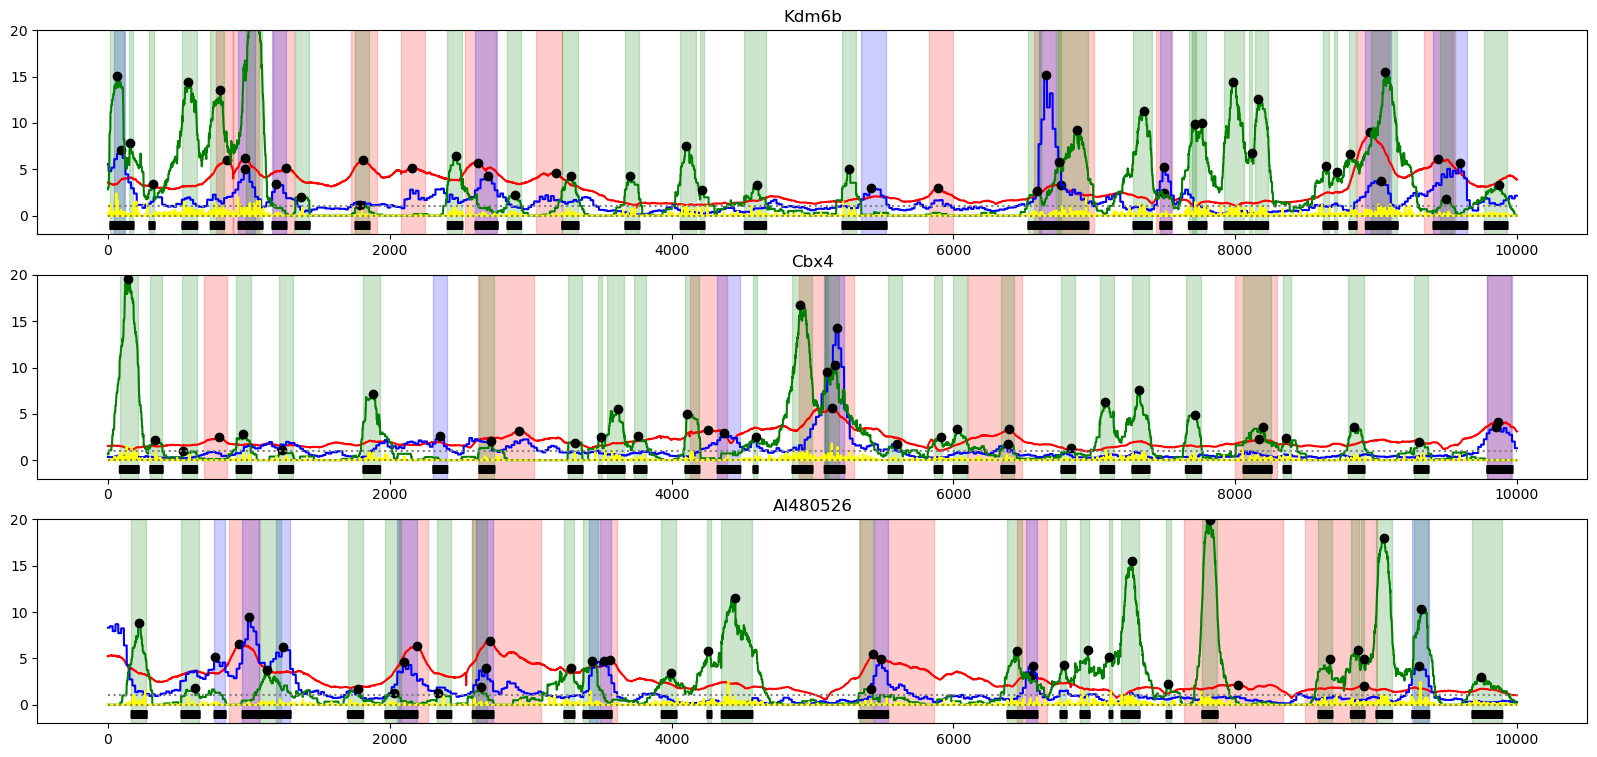

In [77]:
genome = 'mm10'
window_kb = 5
w = 100
prominence = {'chip':1,'atac':2,'chip_peak':1}
colors = {'chip':'red','atac':'blue','chip_peak':'green'}

#infile = f'~/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered_clustered.bed'
#promoterome = pd.read_csv(infile, sep='\t')

infile = f'~/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered_clustered_sorted.bed'
promoterome = pd.read_csv(infile, sep='\t',header=None)
promoterome.columns = ['chr','start','end','strand','black_listed','gene','id']

my_genes = np.array(['Tcstv3','Erdr1','Grb10','Phc1','Cldn34d','Phf10','H2az1','Dnajb14','Srsf6','Brox','Aida','Sox2','Klf4','Stat5a','Stat5b','Tert'])
my_genes = np.array(['Cbx4','Kdm6b','AI480526'])
idx_prom, idx_g = np.where(promoterome.gene.values[:,None] == my_genes[None,:])
#idx_prom = promoterome.sample(20).index

# get total number of TFs
infile = f'../resources/experimentList_v3_{genome}_TFs_only_QC_filtered.tab'
chip_experiment = pd.read_csv(infile, sep='\t',index_col=0)
N_tf = np.unique(chip_experiment.antigen.values).shape[0]

# get atac sample names
atac_samples = pd.read_csv('/home/jbreda/ATACseq/resources/SraRunTable.txt',sep=',')
atac_samples = atac_samples.loc[:,['Run','Sample Name']]
#atac_peaks = get_atac_peaks()

# load chip peak sparse tensor
infile = f'/home/jbreda/ChIP_atlas/results/{genome}/Peak_tensors/Window_pm5kb/PeakCenter_sparse_tensor_prom_tf_position.pt'
Chip_peaks_prom_tf_pos = torch.load(infile)

# initialize figure
fig, axes = plt.subplots(len(idx_prom),1,figsize=(20,3*len(idx_prom)))
infile = f'../results/{genome}/Summed_TF_chip_prom_pm{window_kb}kb.bw'
#infile = f'../results/{genome}/TF_mean_chip/E2f1.bw'
with bw.open(infile) as fin:
    for f,prom in enumerate(idx_prom):
        # get promoter coordinates
        chrom = promoterome.at[prom,'chr']
        start = promoterome.at[prom,'start']
        end = promoterome.at[prom,'end']
        strand = promoterome.at[prom,'strand']

        signal = {}
        peaks = {}
        peak_properties = {}
        #intervals = {}

        # get chip signal
        signal['chip'] = np.array(fin.values(chrom, start, end))
        signal['chip'][np.isnan(signal['chip'])] = 0
        signal['chip'] = signal['chip'] / N_tf *30

        # get chip peaks sparse tensor
        Chip_peaks_tf_pos = Chip_peaks_prom_tf_pos[prom].to_dense()
        if strand == '-':
            Chip_peaks_tf_pos = Chip_peaks_tf_pos.flip(0)
        Chip_peaks_tf_pos = Chip_peaks_tf_pos.numpy()
        #Chip_peaks_tf_pos[Chip_peaks_tf_pos < 250] = 0
        Chip_peaks_tf_pos = Chip_peaks_tf_pos.sum(0)
        Chip_peaks_tf_pos /= 1000
        signal['chip_peak'] = moving_average(Chip_peaks_tf_pos, w)*w

        # get atac signal
        X = get_atac_data(chrom.replace('chr',''),start,end,atac_samples['Run'].values)
        #idx = (atac_peaks.chrom == chrom.replace('chr','')) * (atac_peaks.end_2 >= start) * (atac_peaks.start_2 <= end) 
        #my_peaks = atac_peaks.loc[idx,:]
        signal['atac'] = np.max(X,axis=1)

        my_peaks = np.zeros(window_kb*2000).astype(bool)
        for track in ['chip','atac','chip_peak']:
            #signal[track] = moving_average(signal[track], w)
            #signal[track] = signal[track] - np.mean(signal[track])
            #signal[track] = signal[track] / np.std(signal[track])
            peaks[track], peak_properties[track] = find_peaks(signal[track],width=20,distance=20,prominence=prominence[track],height=0)
            #intervals[track] = get_signal_gt_th(signal[track], 1, 100)

            if track in ['atac','chip_peak']:
                for l,r in zip( np.floor(peak_properties[track]['left_ips']).astype(int), np.ceil(peak_properties[track]['right_ips']).astype(int)):
                    my_peaks[l:r] = True

        # close small gaps
        peak_idx = np.where(my_peaks)[0]
        to_add = np.array([])
        for i,p in enumerate(peak_idx[:-1]):
            d = peak_idx[i+1] - p
            if (d > 1) and (d < 50):
                to_add = np.concatenate([to_add,np.arange(p+1,peak_idx[i+1])])
        my_peaks[to_add.astype(int)] = True
        peak_idx = np.where(my_peaks)[0]

        ax = axes[f]


        for track in ['chip','atac','chip_peak']:
            ax.plot(signal[track],color=colors[track])
            for i in range(len(peaks[track])):
                peak = peaks[track][i]
                l = peak_properties[track]['left_ips'][i]
                r = peak_properties[track]['right_ips'][i]
                y = signal[track][peak]
                #ax.plot([l,peak,r],3*[y], "-|")
                ax.plot(peak,y, "o", color='black')
                ax.axvspan(l,r, color=colors[track], alpha=0.2)
                #ax.plot(l,y, '>')
                #ax.plot(r,y, '<')

        ax.plot(Chip_peaks_tf_pos,color='yellow')

        ax.plot(peak_idx,[-1]*peak_idx.shape[0],'|',color='black')
        
        
        #ax.plot(np.sqrt(signal['chip']*signal['atac']*signal['chip_peak']),color='purple')
        #ax.plot(np.concatenate([signal['chip'][None,:],signal['atac'][None,:],signal['chip_peak'][None,:]],0).max(0),color='purple')
        #ax.errorbar(0-10,np.mean(signal['chip']),yerr=np.std(signal['chip']),color=colors['chip'])
        #ax.errorbar(window_kb*2000+10,np.mean(signal['atac']),yerr=np.std(signal['atac']),color=colors['atac'])
        ax.plot([0,window_kb*2000],[0,0],':',color='gray')
        ax.plot([0,window_kb*2000],[1,1],':',color='gray')

        #ax.plot(X)

        #for i in range(my_peaks.shape[0]):
        #    peak = my_peaks.iloc[i,:]
        #    ax.axvspan(peak.start_2-start, peak.end_2-start, color='blue', alpha=0.5)

        if ax.get_ylim()[1] > 20:
            ax.set_ylim(-2,20)
                
        ax.set_title(f'{promoterome.at[prom,"gene"]}') 

In [5]:
genome = 'mm10'
window_kb = 5
w = 100
prominence = {'chip':1,'atac':2}

# load promoterome
infile = f'~/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered_clustered_sorted.bed'
promoterome = pd.read_csv(infile, sep='\t',header=None)
promoterome.columns = ['chr','start','end','strand','black_listed','gene','id']

# load atac sample names
atac_samples = pd.read_csv('/home/jbreda/ATACseq/resources/SraRunTable.txt',sep=',')
atac_samples = atac_samples.loc[:,['Run','Sample Name']]

# load chip peak sparse tensor
infile = f'/home/jbreda/ChIP_atlas/results/{genome}/Peak_tensors/Window_pm5kb/PeakCenter_sparse_tensor_prom_tf_position.pt'
Chip_peaks_prom_tf_pos = torch.load(infile)

# create reg. region matrix and output bed file
Regulatory_regions = np.zeros([idx_prom.shape[0],window_kb*2000]).astype(bool)
Regulatory_regions_bed = pd.DataFrame(np.zeros([0,6]))
Regulatory_regions_bed.columns = ['chr','start','end','name','score','strand']

# get promoters subset
my_genes = np.array(['Tcstv3','Erdr1','Grb10','Phc1','Cldn34d','Phf10','H2az1','Dnajb14','Srsf6','Brox','Aida','Sox2','Klf4','Stat5a','Stat5b','Tert'])
idx_prom, idx_g = np.where(promoterome.gene.values[:,None] == my_genes[None,:])
idx_prom = promoterome.sample(20).index

for k,prom in enumerate(idx_prom):

    # get promoter coordinates
    chrom = promoterome.at[prom,'chr']
    start = promoterome.at[prom,'start']
    end = promoterome.at[prom,'end']
    strand = promoterome.at[prom,'strand']

    # initialize signals
    signal = {}
    peaks = {}
    peak_properties = {}

    # get chip peaks sparse tensor
    Chip_peaks_tf_pos = Chip_peaks_prom_tf_pos[prom].to_dense()
    if strand == '-':
        Chip_peaks_tf_pos = Chip_peaks_tf_pos.flip(0)
    Chip_peaks_tf_pos = Chip_peaks_tf_pos.numpy().sum(0)/1000
    signal['chip'] = moving_average(Chip_peaks_tf_pos, w)*w

    # get atac signal
    X = get_atac_data(chrom.replace('chr',''),start,end,atac_samples['Run'].values)
    signal['atac'] = np.max(X,axis=1)
    
    # find peaks in chip and atac signals
    my_peaks = np.zeros(window_kb*2000).astype(bool)
    for track in ['atac','chip']:
        peaks[track], peak_properties[track] = find_peaks(signal[track],width=20,distance=20,prominence=prominence[track],height=0)
        for l,r in zip( np.floor(peak_properties[track]['left_ips']).astype(int), np.ceil(peak_properties[track]['right_ips']).astype(int) ):
            my_peaks[l:r] = True

    # close small gaps
    peak_idx = np.where(my_peaks)[0]
    to_add = np.array([])
    for i,p in enumerate(peak_idx[:-1]):
        d = peak_idx[i+1] - p
        if (d > 1) and (d < 50):
            to_add = np.concatenate([to_add,np.arange(p+1,peak_idx[i+1])])
    my_peaks[to_add.astype(int)] = True
    peak_idx = np.where(my_peaks)[0]

    Regulatory_regions[k,:] = my_peaks

    # add peaks to bed file
    reg_start = None
    reg_end = None
    name = promoterome.at[prom,'id']
    s = 0
    for i in peak_idx:

        # if new region starts
        if reg_start is None:
            reg_start = i
            reg_end = i
            continue
        
        # if region continues expand
        if i == reg_end + 1:
            reg_end = i
        
        # if region ends add to bed and start new region
        else:
            s += 1
            Regulatory_regions_bed = pd.concat([Regulatory_regions_bed,pd.DataFrame({'chr':chrom,'start':start+reg_start,'end':start+reg_end,'name':name,'score':reg_end-reg_start,'strand':strand},index=[s])],axis=0)
            reg_start = i
            reg_end = i
    
    # add last region if any
    if reg_start is not None:
        s += 1
        Regulatory_regions_bed = pd.concat([Regulatory_regions_bed,pd.DataFrame({'chr':chrom,'start':start+reg_start,'end':start+reg_end,'name':name,'score':reg_end-reg_start,'strand':strand},index=[s])],axis=0)
        
# fix types
Regulatory_regions_bed.chr = Regulatory_regions_bed.chr.astype(str)
Regulatory_regions_bed.start = Regulatory_regions_bed.start.astype(int)
Regulatory_regions_bed.end = Regulatory_regions_bed.end.astype(int)
Regulatory_regions_bed.name = Regulatory_regions_bed.name.astype(str)
Regulatory_regions_bed.score = Regulatory_regions_bed.score.astype(int)
Regulatory_regions_bed.strand = Regulatory_regions_bed.strand.astype(str)


In [71]:
N = 24000
M = 1000

A = (np.random.randint(0,10,[N,M])==9).astype(int)
np.save('A.npy',A)
print(A.nbytes/1e6, 'MB')
! ls -lh A.npy

B = A.astype(bool)
np.save('B.npy',B)
print(B.nbytes/1e6, 'MB')
! ls -lh B.npy

C = torch.sparse_coo_tensor(torch.tensor(np.where(B)),torch.ones(np.sum(B)),B.shape)
torch.save(C,'C.pt')
! ls -lh C.pt

192.0 MB
-rw-rw-r--. 1 jbreda jbreda 184M 16. Jul 11:31 A.npy
24.0 MB
-rw-rw-r--. 1 jbreda jbreda 23M 16. Jul 11:31 B.npy
-rw-rw-r--. 1 jbreda jbreda 46M 16. Jul 11:31 C.pt


# Plot peak per promoter distribution

(<matplotlib.patches.Rectangle at 0x7fb3e212f2f0>,
 (<matplotlib.patches.ConnectionPatch at 0x7fb3e13a7b90>,
  <matplotlib.patches.ConnectionPatch at 0x7fb3dd8cfe60>))

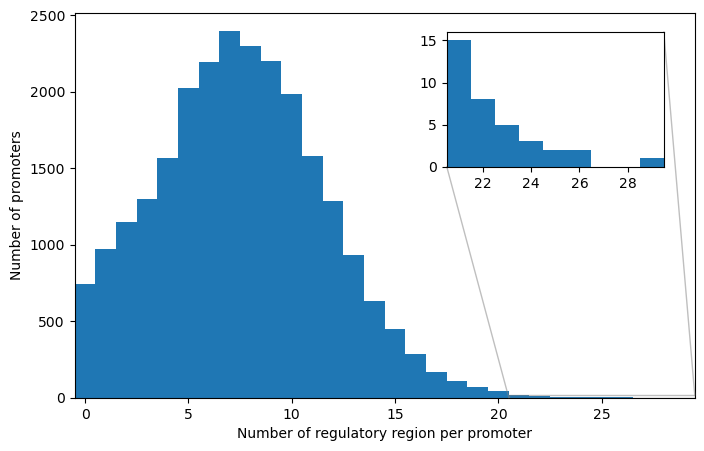

In [117]:
genome = 'mm10'
window_kb = 5
w = 100
prominence = {'chip':1,'atac':2}

# load promoterome
infile = f'~/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered_clustered_sorted.bed'
promoterome = pd.read_csv(infile, sep='\t',header=None)
promoterome.columns = ['chr','start','end','strand','black_listed','gene','id']

# load regulatory regions
infile = f'../results/{genome}/regulatory_regions_pm{window_kb}kb.bed'
Regulatory_regions_bed = pd.read_csv(infile, sep='\t')

# count unique names in regulatory regions
Peak_per_prom = Regulatory_regions_bed.name.value_counts().values
# add zeros for missing promoters
n_missing = promoterome.shape[0] - Peak_per_prom.shape[0]
if n_missing > 0:
    Peak_per_prom = np.concatenate([Peak_per_prom,np.zeros(n_missing)])

bins = np.arange(Peak_per_prom.max()+2)-0.5

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(Peak_per_prom,bins=bins,width=1)
ax.set_xlabel('Number of regulatory region per promoter')
ax.set_ylabel('Number of promoters')
ax.set_xlim(bins[0],bins[-1])
# add inlet with zo0m on x > 20
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
axins.hist(Peak_per_prom,bins=bins,width=1)
axins.set_xlim(20.5,Peak_per_prom.max()+.5)
axins.set_ylim(0,16)
ax.indicate_inset_zoom(axins)
